<h1>
<hr style=" border:none; height:3px;">
<center> Points de fuite : Exploration et proposition d'algorithmes de détection des VNP </center>
<hr style=" border:none; height:3px;">
</h1>

## **Carte des données (Dataset Card)**

Pour cette partie, nous avons utilisé le dossier intitulé 'Road_Annotated_Dataset', comprenant 219 images de routes annotées avec des VNPs et d'autres classes (pour plus de détails, veuillez vous référer à la section 'Aperçu Road_Annotated_Dataset'). Ces images représentaient principalement des routes urbaines avec un marquage au sol clair, ainsi que quelques perturbations (telles que des virages, des ponts, des ombres, des arbres, ...).

Voici un petit visuel du dataset utilisé :

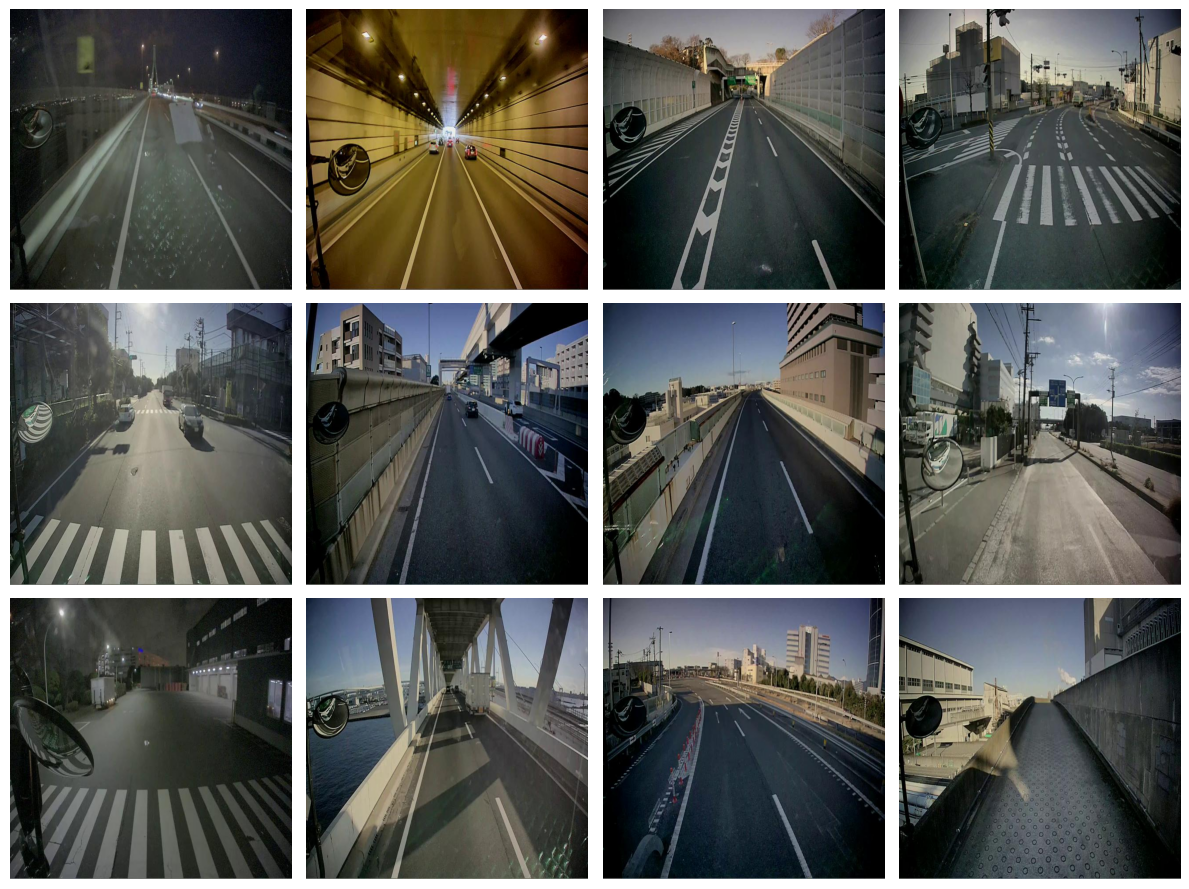

In [48]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataset_path = "C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train"

# Récupérer une liste de fichiers avec l'extension .jpg (extension contenant les images non annotées)
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

random_images = random.sample(image_files, 12)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    if i < len(random_images):
        # Charger et afficher l'image
        img = mpimg.imread(os.path.join(dataset_path, random_images[i]))
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


### Aperçu Road_Annotated_Dataset

Le dataset contient un total de 219 images, réparties en différents sous-ensembles pour les besoins de l'apprentissage automatique :
- Ensemble d'entraînement : 154 images
- Ensemble de validation : 43 images
- Ensemble de test : 22 images

Chaque image est annotée avec les classes suivantes telles que définies dans le fichier `classes.csv` :
- `road-lane`
- `road-line`
- `railing`
- `background`
- **`vnp`** (Classe d'intérêt pour le projet)
- `zebra`

Les annotations présentes dans le dataset sont essentielles pour l'identification et la classification des différents éléments routiers, en particulier pour la détection du point de fuite qui est l'intérêt principal du projet.

### Accès

Le dataset est téléchargeable à l'URL suivante : [Vanishing Point and Road Detection Dataset](https://universe.roboflow.com/vanishing-point-and-road-detection/vanishingpointdetection)

Lors de la tentative de téléchargement du dataset, une fenêtre pop-up offre deux options pour le format des annotations :
- Segmentation JSON COCO
- Masques de segmentation sémantique MASK (L'option pour laquelle nous avons opté)


## **Analyse du Dataset** 

In [49]:
#Créons un chemin pour le dossier Dataset à l'aide du module os

import os
path = os.getcwd() + '\Road_Annotation_Dataset'
print(path)

c:\Users\Maamar\Desktop\VanishingPointDetection_CS\Road_Annotation_Dataset


Affichons une image et le masque correspondant :

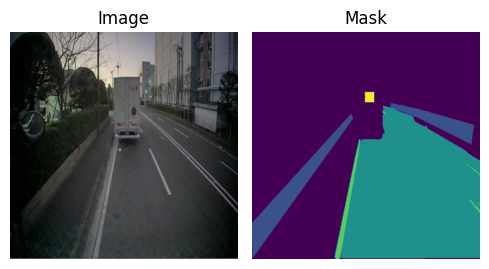

In [50]:
import matplotlib.pyplot as plt
from PIL import Image

image_1 = Image.open('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160.jpg')
image_2 = Image.open('Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160_mask.png')

image_path_1 = 'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160.jpg'

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot the first image
axes[0].imshow(image_1)
axes[0].axis('off')  # Hide axes for image 1
axes[0].set_title('Image') # Optional title

# Plot the second image
axes[1].imshow(image_2)
axes[1].axis('off')  # Hide axes for image 2
axes[1].set_title('Mask') # Optional title

# Display the images
plt.tight_layout()
plt.show()


# Première partie : Calcul du point de fuite

## 1. Test avec les fonctions disponibles sur OpenCV :

Calculons en un premier lieu les coordonnées du point de fuite du masque généré fourni par le dataset pour comparer avec les tentatives de calcul de nos algorithmes :

In [51]:
import cv2
import numpy as np

# On charge l'image mask
mask_path = 'Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160_mask.png' 
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# On identifie les pixels de valeur = 4 (vanishing point)
vp_pixels = np.where(mask == 4)

# Calculons le centroïde des pixels de valeur = 4
if vp_pixels[0].size > 0 and vp_pixels[1].size > 0:
    vp_x = np.mean(vp_pixels[1])
    vp_y = np.mean(vp_pixels[0])
    ground_truth_vp = (int(vp_x), int(vp_y))
else:
    ground_truth_vp = None

print("Ground truth VP:", ground_truth_vp)


Ground truth VP: (329, 185)


Nous allons ensuite appliquer quelques fonctions disponibles sur OpenCV en utilisant les paramètres par défaut pour tenter de trouver le point de fuite dans cette image. La démarche à suivre est bien classique : 

- Conversion de l'image en niveaux de gris.
- Application d'une égalisation d'histogramme pour améliorer le contraste (facultative).
- Utilisation du détecteur d'arêtes de Canny pour trouver les arêtes (edges).
- Détection des segments de ligne dans l'image à l'aide de la transformée de Hough probabiliste.
- Accumulation des points d'extrémité des segments de ligne détectés pour trouver les intersections.
- Application du regroupement K-Means aux intersections pour trouver le centre du regroupement, que nous considérerons comme le point de fuite.

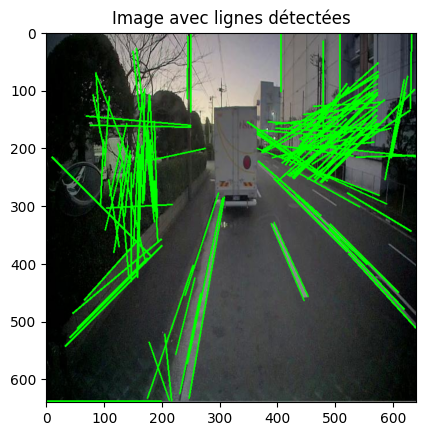

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image_path = image_path_1 
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Égalisation d'histogramme (optionnelle pour améliorer le contraste)
equalized_image = cv2.equalizeHist(gray_image)

# Appliquons le filtre de Canny pour détecter les bords
edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

# Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

# Trouvons les intersections des lignes pour calculer le point de fuite
intersections = []
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            intersections.append((x1, y1))
            intersections.append((x2, y2))

# Affichage de l'image originale avec les lignes détectées
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec lignes détectées')
plt.show()


On pourrait réaujuster les paramètres et appliquer quelques filtres (ignorer les lignes avec un angle horizontal par exemple) afin de ne détecter que les lignes intéressantes et maximiser la chance de trouver le point de fuite idéal. Mais pour ce premier essai, nous avions décidé de ne travailler qu'avec les fonctions classiques d'OpenCV et tenter de nous rapprocher le plus possible du point de fuite en ajustant au minimum les paramètres pour notre cas d'usage.

### **Clustering appliqué pour détecter le point de fuite :** 

Lorsqu'on détecte des segments de ligne dans une image, les points terminaux de ces segments sont souvent proches de là où ces lignes, si elles étaient prolongées à l'infini, se rencontreraient. On décide alors de calculer la moyenne de ces points pour approximer d'une manière grossière le point de fuite réel et voici pourquoi :

- Convergence des Lignes : Même si chaque segment de ligne détecté ne s'étend pas jusqu'au point de fuite réel, les extrémités des segments sont plus proches de ce point que d'autres parties des lignes. En moyenne, ils pointent tous vers le point de fuite.

- Effet de la Moyenne : Prendre la moyenne de ces points terminaux (calcul du centroïde des points) est une façon de trouver le "centre de masse" de ces indications. Si les lignes sont correctement détectées et si elles représentent des caractéristiques qui convergent effectivement vers un point de fuite, alors leur centroïde sera une estimation raisonnable de ce point.

- Filtrage du Bruit : En utilisant la moyenne, on minimise l'effet du bruit et des erreurs de détection individuelles. Chaque ligne peut être affectée par des facteurs tels que les ombres, les interruptions dans les marquages au sol, ou des erreurs dans l'algorithme de détection des lignes. La moyenne aide à "lisser" ces erreurs, donnant une estimation plus stable où la majorité des lignes semble converger.

#### Clustering sur l'ensemble des points

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


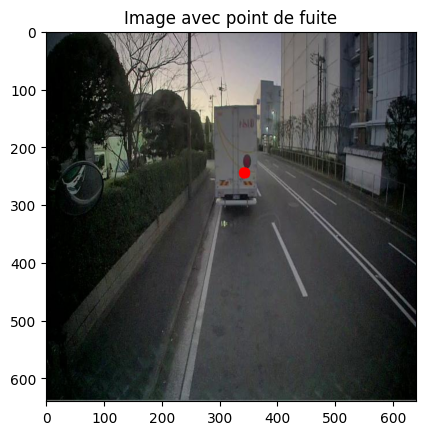

In [53]:
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt

# Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

# Le centre du cluster représente le point de fuite
vanishing_point = kmeans.cluster_centers_

# Chargeons notre image originale
image_path = image_path_1
image = cv2.imread(image_path)

# Dessinons le point de fuite sur l'image
cv2.circle(image, (int(vanishing_point[0][0]), int(vanishing_point[0][1])), 10, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec point de fuite')
plt.show()


Calculons l'erreur de calcul en utilisant la distance euclidienne (l'erreur est exprimée en pixel): 

In [9]:
error = np.sqrt((vanishing_point[0][0] - ground_truth_vp[0]) ** 2 + (vanishing_point[0][1] - ground_truth_vp[1]) ** 2)
error

61.999790055629575

Dans une image de 640x640, une erreur de 61.99 pixels peut être considérée comme significative. Pour avoir un contexte, si on trace un cercle avec un rayon de 61.99 pixels sur l'image, le point de fuite détecté pourrait se trouver n'importe où sur le périmètre de ce cercle par rapport au point de fuite réel.

Visuellement, cela pourrait être interprété comme une déviation notable du point où les lignes semblent converger. Sur une route, cela pourrait affecter la perception de la direction ou la trajectoire.

## 1. Une première proposition d'algorithme (Focus sur le clustering) : 

Pour cette première proposition, nous avons décidé de nous concentrer sur 2 points essentiels :
- Filtrage des lignes : Ignorer les lignes verticales (x1 = x2) et horizontales (y1 = y2) qui ne portent pas d'informations importantes quant au VNP.
- Clustering sur l'ensemble des points 'proches' du point de fuite : Pour bien comprendre cette idée nous avons crée un petit shéma illustrant l'interrêt porté à l'algorithme de clustering

<center><img src='Shéma explicatif de la proposition 1.png' width=500></center>

L'idée de déterminer quelle extrémité est "la plus proche" du point de fuite n'est pas toujours trivial sans calculer réellement les intersections ou sans avoir une analyse approfondie de l'orientation et de la pente de chaque ligne par rapport à l'ensemble de la scène. Dans notre cas 'Images de route' le point de fuite semble toujours plus proche de l'extrémité la plus haute, nous allons alors modifier notre approche et tester notre hypothèse :

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


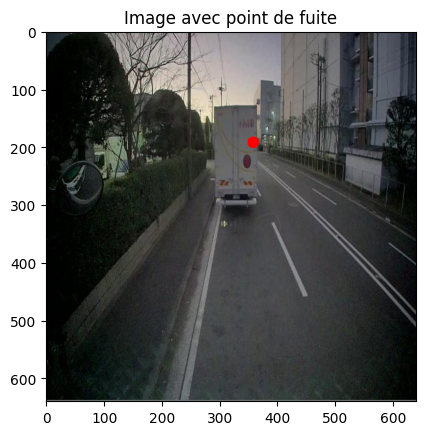

In [54]:
intersections = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calcule de la pente pour filtrer les lignes horizontales et verticales
        if x2 - x1 != 0:  # Pour éviter la division par zéro
            slope = (y2 - y1) / (x2 - x1)
            # Filtrer les lignes presque horizontales et verticales
            if abs(slope) > 0.1:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Sélectionner le point avec le plus grand 'y', donc le plus bas visuellement
                if y1 > y2:
                    intersections.append((x2, y2)) # L'axe des ordonnées est inversé dans les images
                else:
                    intersections.append((x1, y1))

# Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

# Le centre du cluster représente le point de fuite
vanishing_point = kmeans.cluster_centers_

# Chargeons notre image originale
image_path = image_path_1
image = cv2.imread(image_path)

# Dessinons le point de fuite sur l'image
cv2.circle(image, (int(vanishing_point[0][0]), int(vanishing_point[0][1])), 10, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec point de fuite')
plt.show()



Calculons l'erreur à nouveau :

In [55]:
error = np.sqrt((vanishing_point[0][0] - ground_truth_vp[0]) ** 2 + (vanishing_point[0][1] - ground_truth_vp[1]) ** 2)
error

30.37038609505154

Nous avons réussi à réduire l'erreur de plus de deux fois. Notre hypothèse s'est avérée valide dans ce cas, qui était relativement simple avec peu de perturbations et une route bien marquée. Nous pourrions même envisager de prétraiter l'image davantage avant de calculer le point de fuite, en ne conservant que les parties intéressantes, notamment via une segmentation préliminaire pour éliminer les arbres et leurs branches, par exemple.

Voyons maintenant la moyenne des erreurs sur l'ensemble des images de notre dataset :

In [56]:
import os

dataset_directory = 'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train'

all_files = os.listdir(dataset_directory)

# On filtre les fichiers pour n'obtenir que les images non annotées
image_paths = [os.path.join(dataset_directory, file) for file in all_files if not file.endswith('_mask.png')]

# Associons chaque image à son masque
mask_paths = [os.path.join(dataset_directory, file.replace('.jpg', '_mask.png')) for file in image_paths]

# Vérifions que chaque image et son masque existent
image_mask_pairs = list(zip(image_paths, mask_paths))
image_mask_pairs = [(img, mask) for img, mask in image_mask_pairs if os.path.exists(img) and os.path.exists(mask)]

# Maintenant, image_mask_pairs contient des paires de chemins d'images et de masques


In [ ]:
image_mask_pairs

Fonction pour extraire le point de fuite du masque

In [57]:
def extract_ground_truth_vp(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    vp_pixels = np.where(mask == 4)  # '4' est la valeur annotée pour le point de fuite
    if len(vp_pixels[0]) > 0 and len(vp_pixels[1]) > 0:
        vp_x = np.mean(vp_pixels[1])
        vp_y = np.mean(vp_pixels[0])
        return (int(vp_x), int(vp_y))
    return None

Fonction pour détecter le point de fuite à partir de l'image

In [59]:
def detect_vanishing_point(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Égalisation d'histogramme (optionnelle pour améliorer le contraste)
    equalized_image = cv2.equalizeHist(gray_image)

    # Appliquons le filtre de Canny pour détecter les bords
    edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

    # Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    # Trouvons les intersections des lignes pour calculer le point de fuite
    intersections = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Calcule de la pente pour filtrer les lignes horizontales et verticales
            if x2 - x1 != 0:  # Pour éviter la division par zéro
                slope = (y2 - y1) / (x2 - x1)
                # Filtrer les lignes presque horizontales et verticales
                if abs(slope) > 0.1:
                    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    # Sélectionner le point avec le plus grand 'y', donc le plus bas visuellement
                    if y1 > y2:
                        intersections.append((x2, y2)) # L'axe des ordonnées est inversé dans les images
                    else:
                        intersections.append((x1, y1))

    # Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
    kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

    # Le centre du cluster représente le point de fuite
    vanishing_point = kmeans.cluster_centers_
    return vanishing_point

Fonction pour calculer l'erreur : 

In [60]:
def calculate_error(vp1, vp2):
    return np.sqrt((vp1[0] - vp2[0][0]) ** 2 + (vp1[1] - vp2[0][1]) ** 2)


On boucle sur le dataset, on applique les fonctions et on calcule l'erreur moyenne

In [61]:
errors = []
for image_path, mask_path in image_mask_pairs:
    gt_vp = extract_ground_truth_vp(mask_path)
    detected_vp = detect_vanishing_point(image_path)
    if gt_vp is not None and detected_vp is not None:
        error = calculate_error(gt_vp, detected_vp)
        errors.append(error)

# Calculer l'erreur moyenne
mean_error = np.mean(errors)
print("Erreur moyenne sur le dataset :", mean_error)


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Erreur moyenne sur le dataset : 105.40779290841182


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Une erreur moyenne de 105 est très significative, revenons à l'hypothèse de départ et calculons l'erreur moyenne pour juger quelle approche généralise au mieux sur le dataset : 

In [62]:
len(errors)

150

In [63]:
len(image_mask_pairs)

154

In [17]:
def detect_vanishing_point_2(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Égalisation d'histogramme (optionnelle pour améliorer le contraste)
    equalized_image = cv2.equalizeHist(gray_image)

    # Appliquons le filtre de Canny pour détecter les bords
    edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

    # Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    # Trouvons les intersections des lignes pour calculer le point de fuite
    intersections = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                intersections.append((x1, y1))
                intersections.append((x2, y2))

    # Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
    kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

    # Le centre du cluster représente le point de fuite
    vanishing_point = kmeans.cluster_centers_
    return vanishing_point

In [18]:
errors = []
for image_path, mask_path in image_mask_pairs:
    gt_vp = extract_ground_truth_vp(mask_path)
    detected_vp = detect_vanishing_point_2(image_path)
    if gt_vp is not None and detected_vp is not None:
        error = calculate_error(gt_vp, detected_vp)
        errors.append(error)

# Calculer l'erreur moyenne
mean_error = np.mean(errors)
print("Erreur moyenne sur le dataset :", mean_error)

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Erreur moyenne sur le dataset : 138.49773428686765


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Conclusion sur cette première approche :

L'erreur moyenne est passée de 105.40 à 138.49, ce qui montre que notre approche permet une légère réduction de l'erreur de détection du point de fuite dans les images. Cependant, il est important de noter que cette approche ne généralise pas de manière optimale sur l'ensemble du dataset.

## 2. Amélioration de la technique de détection des intersections :  

Cette fois-ci, nous allons affiner notre approche pour la détection du point de fuite en considérant les points d'intersection des différentes lignes détectées. Pour ce faire, nous allons utiliser les paramètres de chaque ligne.

Pour chaque ligne détectée, nous allons calculer sa pente et son intercept. Ceci nous permettra de représenter chaque ligne sous la forme d'une équation linéaire : 
$$ y = mx + c $$
où \( m \) est la pente et \( c \) l'intercept.

Ensuite, nous allons trouver les intersections : le point où deux lignes se croisent peut être trouvé en résolvant leurs équations simultanément. Si nous avons deux lignes :
$$ y = m_1x + c_1 $$
et
$$ y = m_2x + c_2 $$
leur intersection \( x \) est donnée par :
$$ x = \frac{c_2 - c_1}{m_1 - m_2} $$
On peut par la suite utiliser cette formule pour trouver \( y \) en substituant \( x \) dans l'une des équations de ligne.

En pratique, en raison du bruit et des erreurs de détection, toutes les lignes ne se croisent pas exactement au même point. Mais nous pouvons trouver un "point de fuite moyen" en calculant la moyenne des coordonnées de toutes les intersections calculées.


Chargeons une nouvelle image du dataset :

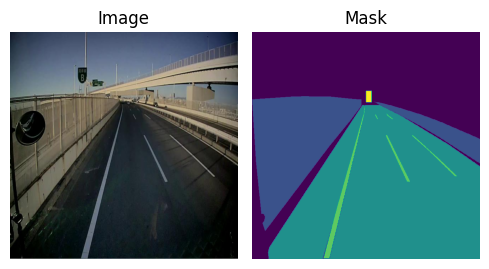

In [24]:
import matplotlib.pyplot as plt
from PIL import Image

image_1 = Image.open('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/29_png.rf.4d09a72732cae6e8bec16f6381c22393.jpg')
image_2 = Image.open('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/29_png.rf.4d09a72732cae6e8bec16f6381c22393_mask.png')

image_path_1 = 'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/29_png.rf.4d09a72732cae6e8bec16f6381c22393.jpg'

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot the first image
axes[0].imshow(image_1)
axes[0].axis('off')  # Hide axes for image 1
axes[0].set_title('Image') # Optional title

# Plot the second image
axes[1].imshow(image_2)
axes[1].axis('off')  # Hide axes for image 2
axes[1].set_title('Mask') # Optional title

# Display the images
plt.tight_layout()
plt.show()

Calcul des coordonnées du point de fuite : 

In [20]:
import cv2
import numpy as np

# On charge l'image mask
mask_path = 'Road_Annotated_Dataset/train/29_png.rf.4d09a72732cae6e8bec16f6381c22393_mask.png' 
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# On identifie les pixels de valeur = 4 (vanishing point)
vp_pixels = np.where(mask == 4)

# Calculons le centroïde des pixels de valeur = 4
if vp_pixels[0].size > 0 and vp_pixels[1].size > 0:
    vp_x = np.mean(vp_pixels[1])
    vp_y = np.mean(vp_pixels[0])
    ground_truth_vp = (int(vp_x), int(vp_y))
else:
    ground_truth_vp = None

print("Ground truth VP:", ground_truth_vp)


Ground truth VP: (327, 183)


Appliquons maintenant les différents filtres initiaux pour la détection des lignes : 

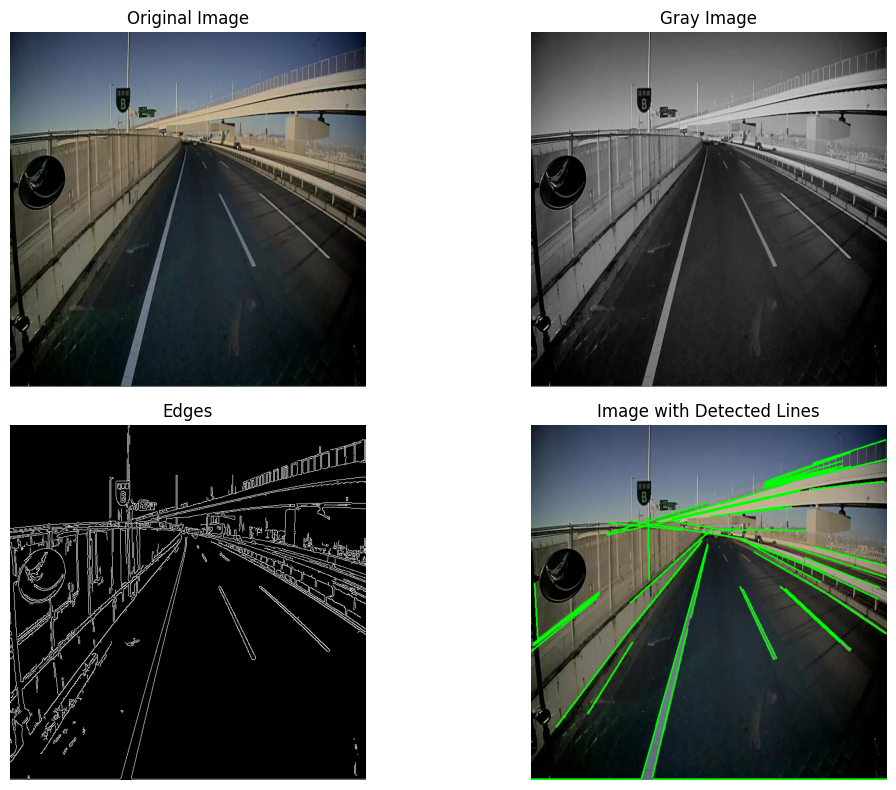

In [25]:

image_path = image_path_1
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_image, 50, 200, apertureSize=3)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Gray Image
plt.subplot(2, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')

# Edges
plt.subplot(2, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.axis('off')

# Lines on Original Image
image_with_lines = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Lines')
plt.axis('off')

plt.tight_layout()
plt.show()

Appliquons maintenant l'approche proposée :

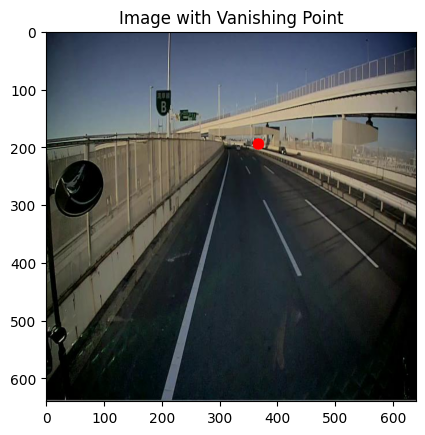

In [26]:
intersections = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        line1 = lines[i][0]
        line2 = lines[j][0]
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2

        # Calcul des pentes
        den1 = float(x2 - x1)
        den2 = float(x4 - x3)
        if den1 != 0 and den2 != 0:  # Éviter la division par zéro
            m1 = (y2 - y1) / den1
            m2 = (y4 - y3) / den2
            c1 = y1 - m1 * x1
            c2 = y3 - m2 * x3

            # Calcul de l'intersection
            if m1 != m2:  # Les lignes ne sont pas parallèles
                intersect_x = (c2 - c1) / (m1 - m2)
                intersect_y = m1 * intersect_x + c1
                intersections.append((intersect_x, intersect_y))

# Calcul de la moyenne des intersections
if intersections:
    intersections = np.array(intersections)
    vp_x, vp_y = np.mean(intersections, axis=0)
    cv2.circle(image, (int(vp_x), int(vp_y)), 10, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Vanishing Point')
plt.show()

Calcul de l'erreur : 

In [27]:
error = np.sqrt((vp_x - ground_truth_vp[0]) ** 2 + (vp_y - ground_truth_vp[1]) ** 2)
error

42.38209057864547

#### Application sur le dataset :

Une erreur de 42 pixels est certes significative compte tenu de la résolution de notre image. Avant d'évaluer l'efficacité de cet algorithme sur notre dataset, nous avons introduit des ajustements supplémentaires pour optimiser la détection des points de fuite. En particulier, nous avons ajouté une condition pour ne retenir que les intersections se trouvant à l'intérieur des dimensions de l'image, excluant ainsi celles qui dépassent les limites physiques de l'image. De plus, pour éviter les erreurs dues aux intersections en bas de l'image qui pourraient être moins pertinentes, nous avons également mis en place un filtrage qui ne conserve que les intersections situées au-dessus d'un certain seuil vertical dynamique. Ces mesures devraient permettre de réduire les erreurs et d'améliorer la précision de notre algorithme. Voyons maintenant comment cet algorithme modifié généralise sur notre dataset :

In [44]:
def detect_vanishing_point_3(image_path):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Égalisation d'histogramme (optionnelle pour améliorer le contraste)
    equalized_image = cv2.equalizeHist(gray_image)

    # Appliquons le filtre de Canny pour détecter les bords
    edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

    # Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    # Trouvons les intersections des lignes pour calculer le point de fuite
    intersections = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            line1 = lines[i][0]
            line2 = lines[j][0]
            x1, y1, x2, y2 = line1
            x3, y3, x4, y4 = line2

            # Calcul des pentes
            den1 = float(x2 - x1)
            den2 = float(x4 - x3)
            if den1 != 0 and den2 != 0:  # Éviter la division par zéro
                m1 = (y2 - y1) / den1
                m2 = (y4 - y3) / den2
                c1 = y1 - m1 * x1
                c2 = y3 - m2 * x3

                # Calcul de l'intersection
                if m1 != m2:  # Les lignes ne sont pas parallèles
                    intersect_x = (c2 - c1) / (m1 - m2)
                    intersect_y = m1 * intersect_x + c1
                    if 0 <= intersect_x < width and 0 <= intersect_y < height:  # Ignorer les intersections hors limites
                        intersections.append((intersect_x, intersect_y))

    # Calcul de la moyenne des intersections
    # Filtrage basé sur le percentile de y
    if intersections:
        intersections = np.array(intersections)
        y_values = intersections[:, 1]
        percentile_75 = np.percentile(y_values, 75)  # Calcul du 75e percentile
        filtered_intersections = intersections[y_values < percentile_75]

        # Clustering des intersections filtrées
        if len(filtered_intersections) > 0:
            kmeans = KMeans(n_clusters=1, random_state=0).fit(filtered_intersections)
            vp_x, vp_y = kmeans.cluster_centers_[0]
        
    vanishing_point = [vp_x, vp_y]
    return vanishing_point

In [31]:
def calculate_error_3(vp1, vp2):
    return np.sqrt((vp1[0] - vp2[0]) ** 2 + (vp1[1] - vp2[1]) ** 2)


In [45]:
errors = []
for image_path, mask_path in image_mask_pairs:
    gt_vp = extract_ground_truth_vp(mask_path)
    detected_vp = detect_vanishing_point_3(image_path)
    if gt_vp is not None and detected_vp is not None:
        error = calculate_error_3(gt_vp, detected_vp)
        errors.append(error)

# Calculer l'erreur moyenne
mean_error = np.mean(errors)
print("Erreur moyenne sur le dataset :", mean_error)

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Erreur moyenne sur le dataset : 58.00101106783502


In [46]:
len(errors)

150

In [47]:
len(image_mask_pairs)

154

#### Conclusion sur la deuxième approche :

La révision de notre algorithme de détection du point de fuite a significativement amélioré la précision des résultats. Avec les ajustements apportés, l'erreur moyenne a été réduite à 58 pixels, contre 105 pixels pour la version précédente de l'algorithme, ce qui représente une amélioration notable de la performance. En outre, l'analyse détaillée a révélé que seulement 4 images sur l'ensemble du dataset n'ont pas pu fournir de point de fuite calculé. Cette situation semble s'expliquer par la présence d'obstacles majeurs, tels que des camions bloquant la vue de la route, ce qui empêche la détection efficace des lignes nécessaires pour calculer le point de fuite. Néanmoins, cette limitation n'affecte pas significativement la qualité globale de l'algorithme, puisque la grande majorité des images ont bénéficié des améliorations apportées. Ces résultats encouragent l'adoption de cet algorithme amélioré pour des applications pratiques, où une estimation précise du point de fuite est cruciale pour la navigation et l'analyse des scènes routières.

# Calcul de l'erreur de calcul du VP : 

## **3D Reconstruction using single view image**

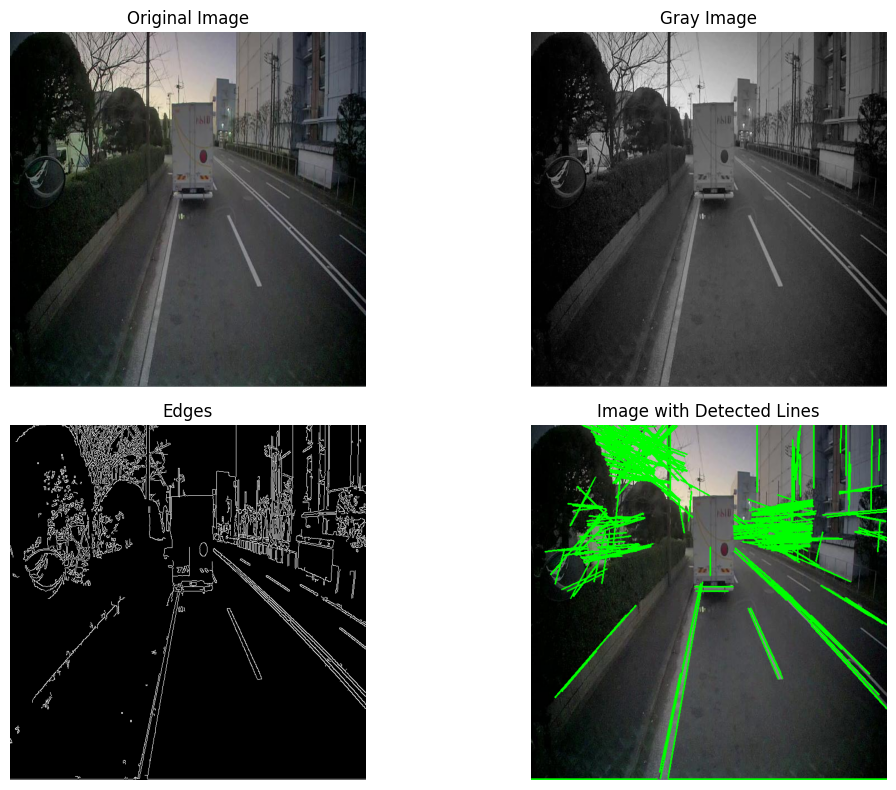

In [6]:
# Load the image
image_path = image_path_1
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection using Canny
edges = cv2.Canny(gray_image, 50, 200, apertureSize=3)

# Detect line segments using the Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

# Create a subplot with 2 rows and 2 columns
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Gray Image
plt.subplot(2, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')

# Edges
plt.subplot(2, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.axis('off')

# Lines on Original Image
image_with_lines = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Lines')
plt.axis('off')

plt.tight_layout()
plt.show()


Clusterization of line segments :

Function calculating orientation of segments : 

In [7]:
import numpy as np

def calculate_orientation(x1, y1, x2, y2):
    """
    Calculate the orientation of a line segment.
    """
    return np.arctan2(y2 - y1, x2 - x1) * (180 / np.pi)


Clustering algorithm :

In [8]:
def cluster_line_segments(lines):
    """
    Cluster line segments based on their orientation.
    """
    orientations = [calculate_orientation(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
    # For simplicity, let's categorize orientations into bins
    # This is a naive approach; for real applications, consider using clustering algorithms like DBSCAN
    bins = np.linspace(-90, 90, 3)  # 10 bins for example
    digitized = np.digitize(orientations, bins)
    clusters = {}
    for i, bin_num in enumerate(digitized):
        if bin_num not in clusters:
            clusters[bin_num] = []
        clusters[bin_num].append(lines[i])
    return clusters


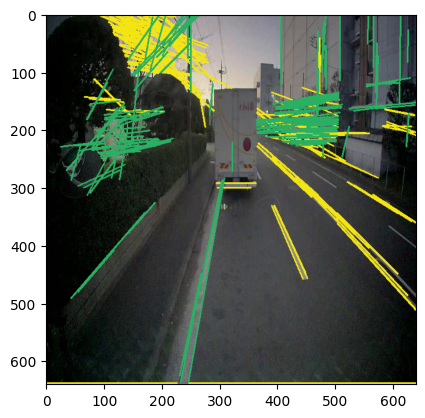

In [9]:
# Prepare lines format and cluster them
lines_format = [line[0] for line in lines]  # Convert to a simpler format
clusters = cluster_line_segments(lines_format)

# Visualize the clusters
for bin_num, cluster_lines in clusters.items():
    color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each cluster
    for x1, y1, x2, y2 in cluster_lines:
        cv2.line(image, (x1, y1), (x2, y2), color, 2)

#cv2.imshow('Clustered Line Segments', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))